# 13 Reverse Quantum Annealing with Portfolio Optimization Problem as an example

## ポートフォリオ最適化問題
  資産運用して投資活動を行うとき、できるだけリスクを回避しながら大きな収益を実現させたい。なので、収益が限定的であるが、リスクが小さい（ないし全くない）資産と見込める収益が大きい分リスクも大きい資産を組み合わせてポートフォリオを作って分散投資を行うのが一般的な戦略になる。

  この時、与えられた一定のリスクでは最大利益を実現したい、または同じ利益を実現する場合できるだけ小さいリスクを取るには、最適なポートフォリオを選ぶ必要がある。現在、よく利用される手法はMarkowitzによる現代ポートフォリオ理論(Modern Portfolio Theory)であり、ポートフォリオを構成する銘柄の間の相関を考慮して、その共分散を最小にさせるような手法になる[1]。
  $$
  \min \sum_{i=1}^{N}\sum_{j=1}^{N}w_{i}w_{j}\sigma_{ij}; \quad \sum_{i=1}^{N}W_{i}=1; \quad \sum_{i=1}^{N}W_{i}\mu_{i}=R
  $$
  ただし、$w_{i}$は各銘柄がポートフォリオ内を占める重みで、$\sigma_{ij}$は銘柄間の共分散である。$\mu_{i}$は各銘柄の期待収益で、$R$はこのポートフォリオの総収益になる。



### Sharpe Ratio

## Reverse Quantum Annealingとは

## Open Jijにおける実装

実際に実装を行う前に、まずは実験用データの生成を行う。
論文[1]にある方法に従って、与えられた初期値を用いて、ブラウン運動によるチャートを生成する。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

#Magic numbers to generate assets
rho = 0.1 # input uniform correlation
mu = 0.075 # expected value
sigma = 0.15 # volatility/standard error
r0 = 0.015 # no risk return

付録Aによって、各時刻においてチャートの運動は前の時刻の運動によって
$$
S(t_{n+1})=S(t_n)\exp(\mu-\frac{1}{2}\sigma^2)\Delta t + \sigma Z_n\sqrt{\Delta t}
$$
のように与えられる。ここの$Z_n$はcholesky分解で作られた一様相関行列$\rho$を従う多変量正規分布になる。

それを実行して適当にチャートをプロットして様子を確認する。全体として初期値から広がっていくが、一部銘柄が大きく上昇または降下するのも確認できる。

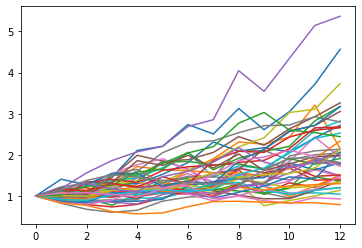

In [2]:
def createZvariables(N, rho):
  rho_mat = np.full((N,N), rho)
  rho_mat[range(N), range(N)] = 1.0
  rho_chole = np.linalg.cholesky(rho_mat)
  zNs_temp = np.random.normal(0, 1, (10000, N))
  zNs = zNs_temp @ rho_chole
  return zNs

def GetNextSt(St, mu, sigma, zN):
  Deltat = 1
  #zN = random.choice(zNs)
  scale = np.exp((mu-0.5*sigma*sigma)*Deltat + sigma*zN*np.sqrt(Deltat))
  NextSt = St * scale
  return NextSt

Nassets = 48
chart = list()
ZList = list()
Zvariables = createZvariables(Nassets, rho)
Zlabels = random.sample([x for x in range(10000)], 12)
for label in Zlabels:
  ZList.append(Zvariables[label])
for iasset in range(Nassets):
  chart_asset = [1.0]
  for month in range(12):
    chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
  chart.append(chart_asset)
  #print(chart_asset)
  plt.plot(list(range(13)), chart_asset)
plt.show()

銘柄のチャートを生成できたので、Sharpe Ratioを計算する。ここ結果を評価するに使うのは実現Sharpe Ratioで、無リスク利回り率を超過した超過収益率の平均と超過収益率の標準偏差で求められる。チャートを確認するとき分かったように、銘柄数が少ない場合は偶然による偏りが大きいので、銘柄を10回生成してその平均Shape Ratioの確認をする。
結果として、銘柄の平均Sharpe Ratioが概ね0.4付近になるのを確認できる。

In [3]:

def CreateAssets(Nassets): 
  chart = list()
  ZList = list()
  Zvariables = createZvariables(Nassets, rho)
  Zlabels = random.sample([x for x in range(10000)], 12)
  for label in Zlabels:
    ZList.append(Zvariables[label])
  for iasset in range(Nassets):
    chart_asset = [1.0]
    for month in range(12):
      chart_asset.append(GetNextSt(chart_asset[month], mu, sigma, ZList[month][iasset]))
    chart.append(chart_asset)
  return chart

#def CalculateSharpeRatio(asset):
#  monthly_log_return = list()
#  #monthly_return = list()
#  for month in range(12):
#    valueChange = asset[month+1]/asset[month] - 1.0 # 毎月の収益
#    log_return = np.log(valueChange+1.0)
#    monthly_log_return.append(log_return)
#    #monthly_return.append(valueChange)
#
#  mean_log_return = np.mean(monthly_log_return)
#  log_volatility = np.std(monthly_log_return,ddof=1)
#
#  #mean_return = np.mean(monthly_return)
#  #volatility = np.std(monthly_return,ddof=1)
#
#
#  return (mean_log_return-np.log(1+r0))/log_volatility
#  #return (mean_return-r0)/volatility
#

def CalculateSharpeRatio(asset):
    monthly_return = list()
    for month in range(12):
      valueChange = asset[month+1]/asset[month] - 1.0 - r0
      monthly_return.append(valueChange)

    annualized_excess_return = np.mean(monthly_return)
    volatility = np.std(monthly_return, ddof=1)

    return(annualized_excess_return/volatility)

def CalculateSharpeRatio_log(asset):
  monthly_log_return = list()
  for month in range(12):
    valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(valueChange)
  mean_log_return = np.mean(monthly_log_return)
  volatility = np.std(monthly_log_return, ddof=1)

  return (mean_log_return-r0)/volatility

def CalculateSharpeRatio_2(asset):
  monthly_log_return = list()
  monthly_return = list()
  for month in range(11):
    log_valueChange = np.log(asset[month+1]/asset[month])
    monthly_log_return.append(log_valueChange)
    valueChange = asset[month+1]/asset[month] - 1.0
    monthly_return.append(valueChange)
  annualized_excess_return = np.mean(monthly_return)
  volatility = np.std(monthly_log_return, ddof=1)

allmean = 0
for ntry in range(10):
  Chart = CreateAssets(48)
  mean_SR = 0.0
  n = 0.
  for asset in Chart:
    assetSR = CalculateSharpeRatio(asset)
    mean_SR = ((mean_SR*n)+assetSR) / (n+1)
    n+=1
  print("SubSet "+ str(ntry)+ " average Sharpe Ratio: " + str(mean_SR))
  allmean = ((allmean*ntry)+mean_SR) / (ntry+1)
  print("Average Sharpe Ratio of all generated: "+ str(allmean))

SubSet 0 average Sharpe Ratio: 0.2854979204019969
Average Sharpe Ratio of all generated: 0.2854979204019969
SubSet 1 average Sharpe Ratio: 0.443004605589808
Average Sharpe Ratio of all generated: 0.36425126299590244
SubSet 2 average Sharpe Ratio: 0.4179591454007754
Average Sharpe Ratio of all generated: 0.3821538904641934
SubSet 3 average Sharpe Ratio: 0.4441362000744768
Average Sharpe Ratio of all generated: 0.39764946786676425
SubSet 4 average Sharpe Ratio: 0.33559363146490173
Average Sharpe Ratio of all generated: 0.38523830058639175
SubSet 5 average Sharpe Ratio: 0.34966032225072013
Average Sharpe Ratio of all generated: 0.37930863753044647
SubSet 6 average Sharpe Ratio: 0.36798320160978476
Average Sharpe Ratio of all generated: 0.3776907181132091
SubSet 7 average Sharpe Ratio: 0.43695612455847166
Average Sharpe Ratio of all generated: 0.38509889391886687
SubSet 8 average Sharpe Ratio: 0.44207804641022114
Average Sharpe Ratio of all generated: 0.3914299108623507
SubSet 9 average Sh

銘柄の確認ができてから、ポートフォリオを組んだ場合の確認を行う。論文に従い、大きな銘柄プールからある特定の数の銘柄をランダムに抽出してその実現Sharpe Ratioを計算する。
そのため、すでに作ってある関数で大きい銘柄数を持つ市場を生成する。

In [4]:
Nassets = 3826 #東証上場銘柄数 十分に大きければなんでも良いはず 
SizeOfPortfolio = 48

index_list = np.arange(Nassets)
Chart = CreateAssets(Nassets)

In [5]:
SR_list = list()
for ntry in range(100):
    selected_charts = list()
    choices = np.random.choice(index_list, size=SizeOfPortfolio, replace=False)
    chartSR_list = list()
    for ichart in choices:
        selected_charts.append(Chart[ichart])
        assetSR = CalculateSharpeRatio(Chart[ichart])
        chartSR_list.append(assetSR)
    print(np.min(chartSR_list),np.max(chartSR_list), np.mean(chartSR_list), np.percentile(chartSR_list, [25,75]))
    #print(np.mean(SR_list), np.percentile(SR_list, [25,75]))
    portfolioChart = np.mean(selected_charts, axis=0)
    print(portfolioChart)
    #print(portfolioChart)
    portfolioSR = CalculateSharpeRatio(portfolioChart)
    SR_list.append(portfolioSR)
    #plt.plot(list(range(13)), portfolioChart)
    #plt.show()
    #print(portfolioSR)
    #print(np.mean(SR_list), np.percentile(SR_list, [25,75]))


-0.18234000607336887 1.0976799791056553 0.476666015348261 [0.35301326 0.63029741]
[1.         1.07821003 1.17581382 1.325072   1.45067997 1.58160241
 1.65147427 1.74311345 1.90561374 2.00056799 2.10508963 2.25399216
 2.4924431 ]
-0.5119658205144213 1.5539860007026682 0.3709831220829864 [0.25339269 0.57076992]
[1.         1.07756808 1.19437616 1.27837779 1.35480274 1.51347584
 1.57355041 1.67076039 1.75225433 1.87058768 2.01478582 2.21589974
 2.44060544]
-0.3975680723705221 0.9620585816940576 0.4141183222937774 [0.20742697 0.61476792]
[1.         1.08744944 1.1963572  1.28218119 1.36161174 1.49584909
 1.59374891 1.7259661  1.83769019 1.97643356 2.14883099 2.30434953
 2.51271743]
-0.20960896996728162 1.4486455287116144 0.4583098297399794 [0.25916661 0.70111706]
[1.         1.07905335 1.20315358 1.31019773 1.41448414 1.51318109
 1.63517505 1.78572982 1.91780873 2.06959298 2.27244145 2.34465765
 2.58209642]
-0.19964614535594094 1.2638079590668772 0.4378060510782212 [0.27739544 0.56042703]


In [6]:
def SRBucket(SR_list):
    Buckets=sorted(SR_list)
    Buckets.reverse()
    GroupedList = list(np.array_split(Buckets,11))
    for i in range(len(SR_list)):
        if   SR_list[i] in GroupedList[0]: SR_list[i]=15
        elif SR_list[i] in GroupedList[1]: SR_list[i]=12
        elif SR_list[i] in GroupedList[2]: SR_list[i]=9
        elif SR_list[i] in GroupedList[3]: SR_list[i]=6
        elif SR_list[i] in GroupedList[4]: SR_list[i]=3
        elif SR_list[i] in GroupedList[5]: SR_list[i]=0
        elif SR_list[i] in GroupedList[6]: SR_list[i]=-3
        elif SR_list[i] in GroupedList[7]: SR_list[i]=-6
        elif SR_list[i] in GroupedList[8]: SR_list[i]=-9
        elif SR_list[i] in GroupedList[9]: SR_list[i]=-12
        elif SR_list[i] in GroupedList[10]: SR_list[i]=-15

def CorrelationBucket(Corr):
    for i in range(len(Corr)):
        for j in range(len(Corr)):
            if Corr[i][j] >= -1.00 and  Corr[i][j] < -0.25: Corr[i][j] = -5
            elif Corr[i][j] >= -0.25 and  Corr[i][j] < -0.15: Corr[i][j] = -3
            elif Corr[i][j] >= -0.15 and  Corr[i][j] < -0.05: Corr[i][j] = -1
            elif Corr[i][j] >= -0.05 and  Corr[i][j] < 0.05: Corr[i][j] = 0
            elif Corr[i][j] >= 0.05 and  Corr[i][j] < 0.15: Corr[i][j] = 1
            elif Corr[i][j] >= 0.15 and  Corr[i][j] < 0.25: Corr[i][j] = 3
            elif Corr[i][j] >= 0.25 and  Corr[i][j] < 1.00: Corr[i][j] = 5

def hi(SR_list, Corr, i):
    h = 0.5*SR_list[i] + np.sum(Corr[i])
    return h

def jij(Corr, i, j):
    return 1./4.*Corr[i][j]


def CreateCorrMat(Chart):
    assets = list()
    for iasset in range(len(Chart)):
        returns = list()
        for month in range(12):
            log_return = np.log(Chart[iasset][month+1]/Chart[iasset][month])
            returns.append(log_return)
        assets.append(returns)
    Chart_pd = pd.DataFrame(assets).T
    pairwise_corr = Chart_pd.corr(method='pearson')
    return pairwise_corr

In [137]:
import heapq
import pandas as pd

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]

for Nassets in NassetsList:
    Solution = np.random.randint(2, size=Nassets)
    for i in range(Nassets):
        Solution[i] = 2*Solution[i] - 1
    print(Solution)
    #相関係数などの準備
    Chart = CreateAssets(Nassets)
    pairwise_corr = CreateCorrMat(Chart)
    SR_list = list()
    for asset in Chart:
        SR_list.append(CalculateSharpeRatio(asset))

    #Bucketの翻訳
    SRBucket(SR_list)
    CorrelationBucket(pairwise_corr)
    #print(pairwise_corr)

    #Greedy Search
    Energies = list()
    for iasset in range(Nassets):
        h = hi(SR_list, pairwise_corr, iasset)
        energyTuple = [-1*abs(h), h , iasset]
        Energies.append(energyTuple)
    heapq.heapify(Energies)
    
    ntry = 0
    print(Energies)
    while(ntry < len(Energies)):
        x, e, i = heapq.heappop(Energies)
        if e > 0:
            Solution[i] = -1.
        else:
            Solution[i] = 1.
        for ie in Energies:
            n = ie[2]
            ie[1] = ie[1] + Solution[i]*(jij(pairwise_corr, i, n) + jij(pairwise_corr, n, i))
            ie[0] = -ie[1]
        ntry+=1
    #heapq.heapify(Energies)
    print(Solution)

    #Genetic Algorithm

def ConvertSolutionToQuboState(solution):
    output = list()
    for i in range(len(solution)):
        if solution[i] == 1:
            output.append(1)
        else: output.append(0)
    return output

QA_init_state = ConvertSolutionToQuboState(Solution)
print(QA_init_state)
    

[ 1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1 -1
  1  1  1 -1  1  1 -1 -1 -1 -1  1 -1  1  1 -1 -1 -1  1  1  1 -1  1  1 -1]
[[-131.5, 131.5, 17], [-127.0, 127.0, 43], [-107.5, 107.5, 25], [-112.0, 112.0, 1], [-110.5, 110.5, 0], [-101.0, 101.0, 12], [-99.5, -99.5, 30], [-98.0, 98.0, 32], [-85.0, 85.0, 36], [-81.5, 81.5, 39], [-90.5, -90.5, 46], [-100.0, 100.0, 47], [-101.0, 101.0, 26], [-74.5, 74.5, 13], [-67.5, 67.5, 6], [-50.0, 50.0, 15], [-61.5, 61.5, 34], [-58.0, 58.0, 35], [-60.0, 60.0, 38], [-46.0, 46.0, 19], [-57.5, -57.5, 20], [-44.5, -44.5, 21], [-65.5, 65.5, 4], [-57.5, 57.5, 11], [-62.0, 62.0, 24], [-86.0, 86.0, 5], [-85.5, 85.5, 2], [-37.5, 37.5, 27], [-37.5, 37.5, 28], [-14.0, -14.0, 29], [-13.5, 13.5, 14], [-19.0, 19.0, 31], [-39.0, -39.0, 7], [-15.5, 15.5, 33], [-33.5, 33.5, 16], [-47.5, 47.5, 3], [-30.0, 30.0, 8], [-57.5, 57.5, 37], [-16.5, 16.5, 18], [-1.5, 1.5, 9], [-2.0, 2.0, 40], [-54.5, 54.5, 41], [-10.5, 10.5, 42], [-8.0, -8.0, 10], [-7.0, 7.

### 普通のQuantum Annealingの解法

先ほど作っていたIsingをそのままQUBOに落としてこんで量子アニーリングのシミュレーターで動かしてみる。

<class 'numpy.ndarray'>


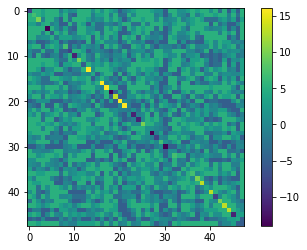

With initialisationL:
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -41., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -41., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -41., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -41., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -41., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -41., 1)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 

In [145]:
from openjij import SQASampler
sampler = SQASampler()

#pairwise_corr = CreateCorrMat(Chart)
#SR_list = list()
#for asset in Chart:
#    SR_list.append(CalculateSharpeRatio(asset))

#Bucketの翻訳
#    SRBucket(SR_list)
#    CorrelationBucket(pairwise_corr)
#    #print(pairwise_corr)

QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = pairwise_corr[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

print(type(QUBO))
import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

print('With initialisationL:')
sampleset = sampler.sample_qubo(QUBO,num_reads=10, initial_state=QA_init_state)
print(sampleset.record)

#With out initilisation
print("")
print('Without initialisation:')
sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

### Reverse Quantum Annealingの場合

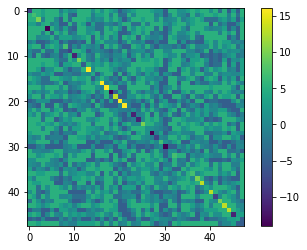

[([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], -267., 1)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], -267., 1)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], -267., 1)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], -267., 1)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], -267., 1)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], -267., 1)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0

In [153]:
sampler = SQASampler()

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]


#for Nassets in NassetsList:
#
#    #相関係数などの準備
#    Chart = CreateAssets(Nassets)
#    pairwise_corr = CreateCorrMat(Chart)
#    SR_list = list()
#    for asset in Chart:
#        SR_list.append(CalculateSharpeRatio(asset))
#
#    #Bucketの翻訳
#    SRBucket(SR_list)
#    CorrelationBucket(pairwise_corr)
#    #print(pairwise_corr)


QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in  range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = pairwise_corr[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]
    
import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

#    print("")
#    init_state = best_forword
#    print(init_state)
#    sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10, schedule=schedule, initial_state = init_state)
#    print(sampleset_RQA.record)

[([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -138., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -94., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -94., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]


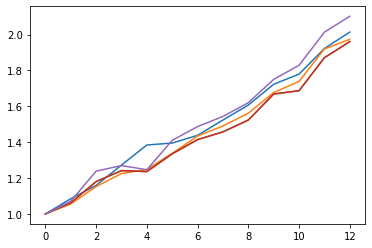

In [158]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 5
TargetS = 0.38
ReverseStep = (1.0 - TargetS) / NReverseStep
beta = 0.5
MC_step = 15
#Reverse Step
#for i in range(NReverseStep):
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, beta, MC_step]
    RQAschedule.append(step_sche)   

init_state = sampleset.record[0][0]
#init_state = None
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
for step in RQAschedule:
    selected_charts = list()
    for i in range(Nassets):
        if init_state[i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart)
    
    sche = [step]
    sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=1, reinitialize_state=False)
    init_state= sampleset_RQA.record[0][0]
    print(sampleset_RQA.record)
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=1, reinitialize_state=False)
#print(sampleset_RQA.record)
pause_initial_state = sampleset_RQA.record[0][0]

[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]


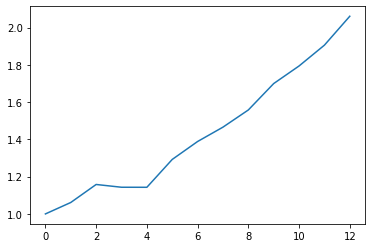

In [170]:
#Create Pause Step
RQAschedule = []
NPauseStep = 5
TargetS = 0.38
beta = 5.0
MC_step = 50
step_sche = [TargetS, beta, MC_step*NPauseStep]
RQAschedule.append(step_sche)

init_state = pause_initial_state
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
for step in RQAschedule:
    selected_charts = list()
    for i in range(Nassets):
        if init_state[i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart)
    
    sche = [step]
    sampleset_RQA = sampler.sample_qubo(QUBO, schedule=sche, initial_state = init_state, num_reads=1, reinitialize_state=False)
    init_state= sampleset_RQA.record[0][0]
    print(sampleset_RQA.record)
forward_initial_state = sampleset_RQA.record[0][0]


[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -46., 1)]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0

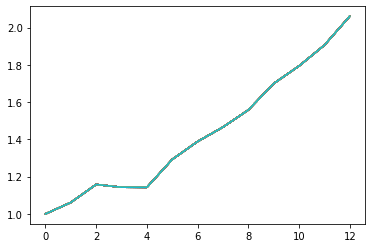

In [171]:
#Create Forward Step
RQAschedule = []
NForwardStep = 50
TargetS = 0.38
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 5.0
MC_step = 5

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, beta, MC_step]
    RQAschedule.append(step_sche)

init_state = forward_initial_state
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
for step in RQAschedule:
    selected_charts = list()
    for i in range(Nassets):
        if init_state[i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart)
    
    sche = [step]
    sampleset_RQA = sampler.sample_qubo(QUBO, schedule=sche, initial_state = init_state, num_reads=1, reinitialize_state=False)
    init_state= sampleset_RQA.record[0][0]
    print(sampleset_RQA.record)
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule.reverse(), initial_state = init_state, num_reads=5, reinitialize_state=False)
#print(sampleset_RQA.record)

print("")
straight = sampler.sample_qubo(QUBO,num_reads=1,initial_state =forward_initial_state)
print(straight.record)

[0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 1 0]
[0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 1 0]
[([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0], -267., 1)]
[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -67., 1)]
[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -37., 1)]
[0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0]
[([0, 0, 0, 0, 0, 0, 0, 1, 0, 

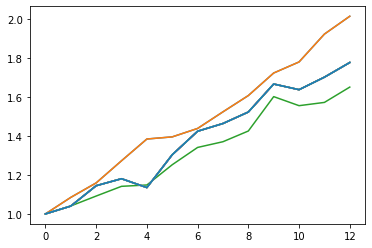

In [173]:
#Create RQA schedule
RQAschedule = []
NReverseStep = 5
NPauseStep = 5
NForwardStep = 5
TargetS = 0.38
ReverseStep = (1.0 - TargetS) / NReverseStep
ForwardStep = (1.0 - TargetS) / NForwardStep
beta = 10.
#Reverse Step
#for i in range(NReverseStep):
for i in range(NReverseStep):
    step_sche = [1.0-i*ReverseStep, 100., 5]
    RQAschedule.append(step_sche)   

#Pause Step
RQAschedule.append([TargetS, 5.0, NPauseStep*10])

#Forward Step
for i in range(NForwardStep):
    step_sche = [TargetS+(i+1)*ForwardStep, 4.8, 50]
    #step_sche = [1.0, 5.0 , 10]
    RQAschedule.append(step_sche)

init_state = sampleset.record[0][0]
#init_state = None
print(init_state)
#sampleset_RQA = sampler.sample_qubo(QUBO, schedule=RQAschedule, initial_state = init_state, num_reads=10, reinitialize_state=False)
for step in RQAschedule:
    selected_charts = list()
    for i in range(Nassets):
        if init_state[i]:
            selected_charts.append(Chart[i])
    portfolioChart = np.mean(selected_charts, axis=0)
    plt.plot(list(range(13)), portfolioChart)
    
    sche = [step]
    sampleset_RQA = sampler.sample_qubo(QUBO, schedule=sche, initial_state = init_state, num_reads=1, reinitialize_state=False)
    init_state= sampleset_RQA.record[0][0]
    print(init_state)

    print(sampleset_RQA.record)

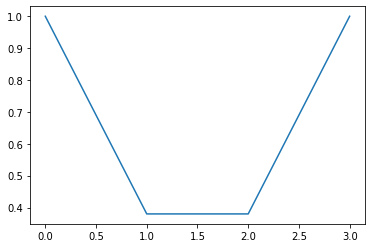

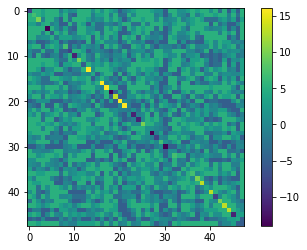

[([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], -206., 1, 0.02083333)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], -216., 1, 0.04166667)
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -220., 1, 0.0625    )
 ([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], -155., 1, 0.        )
 ([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0], -198., 1, 0.04166667)
 ([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], -1

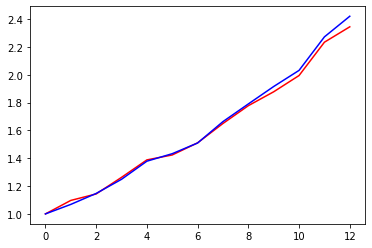

In [174]:
from openjij import SQASampler
from dwave.system import DWaveSampler, EmbeddingComposite
#sampler = SQASampler()

token = 'DEV-be7e13c12cb3fb3a6e7f2e0c2a3650aab06cfbc1'
endpoint = 'https://cloud.dwavesys.com/sapi/'

dw_sampler = DWaveSampler(solver='Advantage_system4.1', token=token)
sampler = EmbeddingComposite(dw_sampler)

NassetsList = [48]#, 30, 36, 42, 48, 54, 60]


# RQA schedule
timing = (0,1,2,3)
Ratio = (1.0,0.38,0.38,1.0)
schedule = list(zip(timing,Ratio))
plt.plot(timing,Ratio)
plt.show()


#for Nassets in NassetsList:
#
#    #相関係数などの準備
#    Chart = CreateAssets(Nassets)
#    pairwise_corr = CreateCorrMat(Chart)
#    SR_list = list()
#    for asset in Chart:
#        SR_list.append(CalculateSharpeRatio(asset))
#
#    #Bucketの翻訳
#    SRBucket(SR_list)
#    CorrelationBucket(pairwise_corr)
#    #print(pairwise_corr)
#

QUBO = np.random.rand(Nassets**2).reshape(Nassets, Nassets)
for i in  range(Nassets):
    for j in range(Nassets):
        QUBO[i][j] = pairwise_corr[i][j]
for i in range(Nassets):
    QUBO[i][i] = QUBO[i][i] + SR_list[i]

import matplotlib.pyplot as plt
plt.imshow(QUBO)
plt.colorbar()
plt.show()

sampleset = sampler.sample_qubo(QUBO,num_reads=10)
print(sampleset.record)

min_forword = 0
for result in sampleset.record:
    if result[1] < min_forword:
        min_forword = result[1]
        best_forword = result[0]
    
selected_charts = list()
for i in range(Nassets):
    if best_forword[i]:
        selected_charts.append(Chart[i])
        chartSR_list.append(assetSR)
portfolioChart = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart,color="r",label="Forward Annealing")

#    print("")
#init_state = best_forword
#    print(init_state)
sampleset_RQA = sampler.sample_qubo(QUBO,num_reads=10,  anneal_schedule=schedule, initial_state = QA_init_state)
print(sampleset_RQA.record)

min_RQA = 0
for result in sampleset_RQA.record:
    if result[1] < min_RQA:
        min_RQA = result[1]
        best_RQA = result[0]
selected_charts = list()
for i in range(Nassets):
    if best_RQA[i]:
        selected_charts.append(Chart[i])
        chartSR_list.append(assetSR)
portfolioChart = np.mean(selected_charts, axis=0)
plt.plot(list(range(13)), portfolioChart,color="b",label="Reverse Annealing")


## 参考文献
1. Harry Markowitz, "Portfolio selection", The journal of finance, 7(1):77–91 (1952)
2. Davide Venturelli, Alexei Kondratyev, "Reverse Quantum Annealing Approach to Portfolio Optimization Problems", Quantum Machine Intelligence volume 1, pages17–30 (2019)
